<a href="https://colab.research.google.com/github/Narmathan56/AI-Math-Tutor/blob/main/Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

✅ Using device: cuda
✅ Epoch 1/26, Loss: 2.7223
✅ Epoch 2/26, Loss: 1.1480
✅ Epoch 3/26, Loss: 0.7075
✅ Epoch 4/26, Loss: 0.5353
✅ Epoch 5/26, Loss: 0.4402
✅ Epoch 6/26, Loss: 0.3750
✅ Epoch 7/26, Loss: 0.3270
✅ Epoch 8/26, Loss: 0.2783
✅ Epoch 9/26, Loss: 0.2283
✅ Epoch 10/26, Loss: 0.1837
✅ Epoch 11/26, Loss: 0.1493
✅ Epoch 12/26, Loss: 0.1265
✅ Epoch 13/26, Loss: 0.1064
✅ Epoch 14/26, Loss: 0.0937
✅ Epoch 15/26, Loss: 0.0818
✅ Epoch 16/26, Loss: 0.0694
✅ Epoch 17/26, Loss: 0.0612
✅ Epoch 18/26, Loss: 0.0559
✅ Epoch 19/26, Loss: 0.0517
✅ Epoch 20/26, Loss: 0.0472
✅ Epoch 21/26, Loss: 0.0420
✅ Epoch 22/26, Loss: 0.0400
✅ Epoch 23/26, Loss: 0.0372
✅ Epoch 24/26, Loss: 0.0348
✅ Epoch 25/26, Loss: 0.0323
✅ Epoch 26/26, Loss: 0.0285


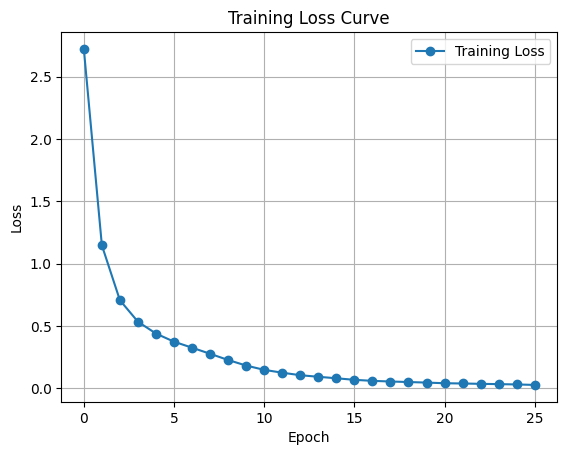

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("✅ Using device:", device)

# Positional Encoding
class PositionalEncoding(nn.Module):
    def __init__(self, embed_size, max_len=5000):
        super().__init__()
        pe = torch.zeros(max_len, embed_size)
        position = torch.arange(0, max_len).unsqueeze(1).float()
        div_term = torch.exp(torch.arange(0, embed_size, 2).float() * (-torch.log(torch.tensor(10000.0)) / embed_size))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer("pe", pe)

    def forward(self, x):
        return x + self.pe[:, :x.size(1)]


# Transformer Model
class MathTransformer(nn.Module):
    def __init__(self, vocab_size, embed_size, num_heads, num_layers, dropout=0.1):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.positional_encoding = PositionalEncoding(embed_size)
        self.transformer = nn.Transformer(
            d_model=embed_size,
            nhead=num_heads,
            num_encoder_layers=num_layers,
            num_decoder_layers=num_layers,
            dropout=dropout,
            batch_first=True
        )
        self.fc_out = nn.Linear(embed_size, vocab_size) # Use the passed vocab_size


    def forward(self, src, tgt, src_padding_mask=None, tgt_mask=None):
        src = self.embedding(src)
        src = self.positional_encoding(src)

        tgt = self.embedding(tgt)
        tgt = self.positional_encoding(tgt)

        output = self.transformer(
            src, tgt,
            src_key_padding_mask=src_padding_mask,
            tgt_mask=tgt_mask
        )
        return self.fc_out(output)

    @staticmethod
    def generate_square_subsequent_mask(sz):
        mask = torch.triu(torch.ones(sz, sz), diagonal=1).bool()
        return mask.masked_fill(mask, float('-inf')).masked_fill(~mask, float(0.0))

    @staticmethod
    def generate_padding_mask(seq, pad_token_id):
        return seq == pad_token_id

    @staticmethod
    def handle_vocab_size(X_batch, y_batch, vocab_size, unk_token=1):
        X_batch = X_batch.clone()
        y_batch = y_batch.clone()
        X_batch[X_batch >= vocab_size] = unk_token
        y_batch[y_batch >= vocab_size] = unk_token
        return X_batch, y_batch

# Dataset
class MathDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return self.X.size(0)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Hyperparameters
vocab_size = len(vocab) # Use the actual vocab size here
embed_size = 1024
num_heads = 32
num_layers =6
dropout = 0.1
pad_token_id = vocab["<pad>"]  # Get pad token id from vocab
num_epochs = 26


# Initialize model, loss, optimizer, scheduler
model = MathTransformer(vocab_size, embed_size, num_heads, num_layers, dropout).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=pad_token_id)
optimizer = optim.Adam(model.parameters(), lr=1e-5, weight_decay=1e-5)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.8)

# Training loop
loss_values = []
for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        # Handle vocab overflow
        X_batch, y_batch = MathTransformer.handle_vocab_size(X_batch, y_batch, vocab_size)

        # Padding and masks
        src_padding_mask = MathTransformer.generate_padding_mask(X_batch, pad_token_id).to(device)
        tgt_input = y_batch[:, :-1]
        tgt_output = y_batch[:, 1:]

        tgt_mask = MathTransformer.generate_square_subsequent_mask(tgt_input.size(1)).to(device)

        # Forward pass
        optimizer.zero_grad()
        output = model(X_batch, tgt_input, src_padding_mask=src_padding_mask, tgt_mask=tgt_mask)

        # Reshape for loss
        output = output.reshape(-1, vocab_size)
        tgt_output = tgt_output.reshape(-1)

        loss = criterion(output, tgt_output)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    loss_values.append(avg_loss)
    scheduler.step()

    print(f"✅ Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}")

# Plot loss
plt.plot(loss_values, marker='o', label="Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Curve")
plt.legend()
plt.grid(True)
plt.show()